# Random Forest Method
### Notes:
#### Steps by Steps to use Random Forest Algorithm 
1)  Load and inspect the dataset.
2)  Preprocess data (e.g., create date and lag features).
3)  Define features (X) and target (y).
4)  Split data into training and testing sets.
5)  Train the RandomForestRegressor.
6)  Make predictions on the test set.
7)  Evaluate model performance.
8)  Predict future cases using the trained model.

In [1]:
# Import libraries
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import joblib

### Data Preprocessing 
#### Collect,sums up and clean the data (remove or insert 0 to any null values, visualise the data 
#### Adding and sorting the data based on date order, scaling the numerical values in suitable range (0 and 1), structuring data by creating sequences past values to be input and target being next value in sequences, and split data into 70% training set and 30% test set.

missing values in dataset: 
date         0
cases_new    0
dtype: int64
length of dataset:  1716
date         datetime64[ns]
cases_new             int64
dtype: object
            count                           mean                  min  \
date         1716  2022-05-31 12:00:00.000000256  2020-01-25 00:00:00   
cases_new  1716.0                    3097.769814                  0.0   

                           25%                  50%                  75%  \
date       2021-03-28 18:00:00  2022-05-31 12:00:00  2023-08-03 06:00:00   
cases_new                131.0                851.5               3246.5   

                           max          std  
date       2024-10-05 00:00:00          NaN  
cases_new              33406.0  5621.640214  
missing values in dataset: 
date         0
cases_new    0
dtype: int64


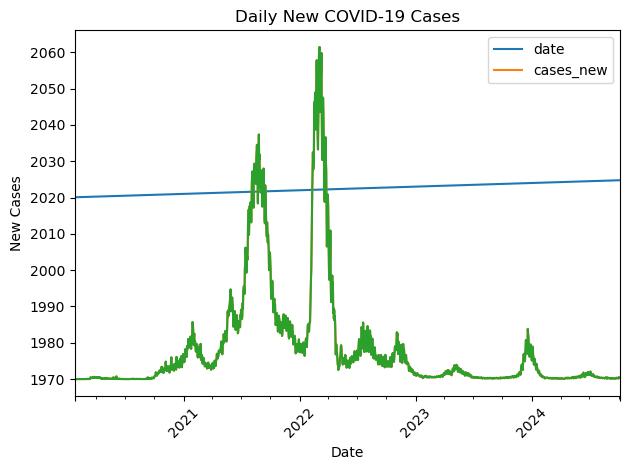

In [4]:
# Load the dataset, only columns date,state,new
# Load the dataset
df = pd.read_csv('../datasets/cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

# Set the frequency of the DataFrame's index to daily ('D')
df_grouped = df_grouped.asfreq('D')

# Check for missing values
print("missing values in dataset: ")
print(df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Check the length of the dataset
print("length of dataset: ", len(df_grouped))

#check df_grouped type of data for both columns
print(df_grouped.dtypes)

#calculate the mean,std, count, min, max, 25%,50%,75%
print(df_grouped.describe().transpose())
df_grouped.plot()
# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

# Check for missing values
print("missing values in dataset: ")
print( df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Plot the total new cases per day
plt.plot(df_grouped['date'], df_grouped['cases_new'])
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Daily New COVID-19 Cases')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to avoid overlap
plt.show()

### Random Forest Algorithms 
#### create a model architecture, define features X and Y, train the model, evaluate the test data on model, predict future case
##### Notes:
1)  Created a lag feature `cases_new_lag1`,helps the model understand past case trends as predictors, could add more lag features if relevant

In [5]:
# Display the aggregated data
display(df_grouped.head(10))

# Get the total number of rows
total_rows = df_grouped.shape[0]
print("Total number of rows:", total_rows)

# sort by date order
df_grouped = df_grouped.sort_values(by='date')

#used to scale data into between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#drop date columns because it doesn't need to be scaled, just cases_new column only
scaled_data = scaler.fit_transform(df_grouped.drop(['date'], axis=1))

# Scaled data (Numpy array) is converted back into dataframe 
df_grouped_scaled = pd.DataFrame(scaled_data, columns=df_grouped.columns[1:])

#original 'date' is added back into new data frame 
df_grouped_scaled['date'] = df_grouped['date'].values

# Prepare the data for Random Forest
# Here we'll use a windowing technique similar to LSTM, but we need to reshape the data differently.
# We will create features for the last N days for predicting the current day's cases_new.

def create_features(data, target_col='cases_new', sequence_length=30):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Last N days
        y.append(data[i][0])  # Current day's cases_new
    return np.array(X), np.array(y)

# Prepare the data for Random Forest model
data_for_rf = df_grouped_scaled.drop(['date'], axis=1).values
X, y = create_features(data_for_rf)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, train_size=0.7, shuffle=False)


,date,cases_new
0,2020-01-25,4
1,2020-01-26,0
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
5,2020-01-30,1
6,2020-01-31,0
7,2020-02-01,0
8,2020-02-02,0
9,2020-02-03,0


Total number of rows: 1716


Unscaled Mean Absolute Error (MAE): 83.1130138339921
Unscaled Mean Squared Error (MSE): 31904.775953705506
Unscaled Root Mean Squared Error (RMSE): 178.6190805980859


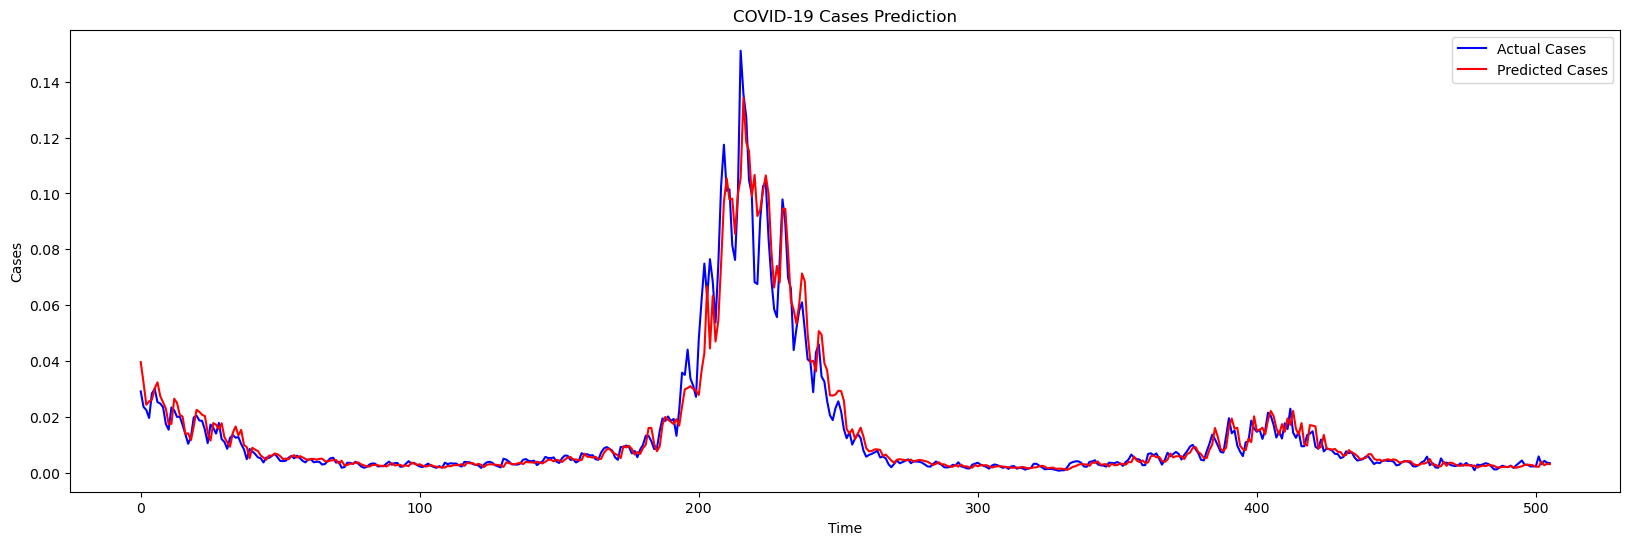

In [7]:
# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train)# Train the model
y_pred = rf_regressor.predict(X_test)# Make predictions

# Rescale predictions and true values back to original scale
y_pred_rescaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

# Calculate MAE and RMSE on original scale
mae_unscaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse_unscaled = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse_unscaled = np.sqrt(mse_unscaled)

print(f"Unscaled Mean Absolute Error (MAE): {mae_unscaled}")
print(f"Unscaled Mean Squared Error (MSE): {mse_unscaled}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse_unscaled}")

# plot the graph for the 
plt.figure(figsize=(20, 6))
plt.plot(y_test, color='blue', label='Actual Cases')
plt.plot(y_pred, color='red', label='Predicted Cases')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()